 # Improved Multi-Task Face Analysis: Age and Gender Prediction



 This notebook implements an enhanced version of the age and gender prediction model with:

 1. Improved bias mitigation strategies

 2. Better data handling

 3. Enhanced model architecture

 4. Comprehensive evaluation



 ## Key Improvements:

 - Age-specific loss weighting

 - Enhanced data augmentation

 - Focal loss for imbalanced classes

 - Uncertainty estimation

 - Comprehensive bias analysis

 ## 1. Imports and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from lime import lime_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
CUDA version: 11.8


## 2. Data Parsing and Loading Functions

In [ ]:
def parse_filepath(filepath):
    """Parse UTKFace filepath to extract age, gender, and race information"""
    try:
        filename = filepath.stem
        age, gender, race, _ = filename.split('_')
        return {
            'filepath': str(filepath),
            'age': int(age),
            'gender': int(gender),  # 0: male, 1: female
            'race': int(race)
        }
    except Exception as e:
        print(f"Error parsing {filepath}: {str(e)}")
        return None

def create_dataset_df(data_dir):
    """Create a DataFrame with image metadata"""
    print(f"Scanning directory: {data_dir}")
    
    data_dir = Path(data_dir)
    
    if not data_dir.exists():
        raise FileNotFoundError(f"Directory not found: {data_dir}")
    
    image_paths = list(data_dir.glob('*.jpg'))
    
    if not image_paths:
        raise ValueError(f"No jpg files found in {data_dir}")
    
    print(f"Found {len(image_paths)} images. Parsing metadata...")
    
    records = []
    for filepath in tqdm(image_paths, desc="Parsing images"):
        record = parse_filepath(filepath)
        if record:
            records.append(record)
    
    df = pd.DataFrame(records)
    
    print("\nDataset statistics:")
    print(f"Total valid images: {len(df)}")
    print(f"Age range: {df['age'].min()} to {df['age'].max()} years")
    print(f"Gender distribution: \n{df['gender'].value_counts(normalize=True).round(3)}")
    
    return df

 ## 3. Data Preprocessing

In [ ]:
class AgeGenderDataset(Dataset):
    """Enhanced dataset class with better augmentation and preprocessing"""
    def __init__(self, df, transform=None, augment=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.augment = augment
        
        bins = [0, 20, 40, 60, 80, 120]
        df['age_group'] = pd.cut(df['age'], bins=bins)
        group_counts = df['age_group'].value_counts()
        max_count = group_counts.max()
        
        self.age_weights = {}
        for interval, count in group_counts.items():
            self.age_weights[interval] = max_count / count
    
    def __len__(self):
        return len(self.df)
    
    def get_age_weight(self, age):
        """Get weight for age-based loss"""
        for interval, weight in self.age_weights.items():
            if interval.left <= age <= interval.right:
                return torch.tensor(weight, dtype=torch.float32)
        return torch.tensor(1.0, dtype=torch.float32)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        image = Image.open(img_path)
        
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        age = self.df.iloc[idx]['age']
        gender = self.df.iloc[idx]['gender']
        
        if self.augment:
            image = self.custom_augment(image)
            
        if self.transform:
            image = self.transform(image)
            
        age_normalized = torch.tensor(age/116.0, dtype=torch.float32)
        gender = torch.tensor(gender, dtype=torch.long)
        
        age_weight = self.get_age_weight(age)
        
        return image, age_normalized, gender, age_weight
    
    def custom_augment(self, image):
        """Custom augmentation pipeline"""
        if random.random() > 0.5:
            image = TF.hflip(image)
        
        if random.random() > 0.5:
            factor = random.uniform(0.8, 1.2)
            image = TF.adjust_brightness(image, factor)
        
        if random.random() > 0.5:
            factor = random.uniform(0.8, 1.2)
            image = TF.adjust_contrast(image, factor)
        
        return image

 ## 4. Improved Model Architecture

In [ ]:
class FocalLoss(nn.Module):
    """Focal Loss for better handling of class imbalance"""
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class ImprovedFaceNet(nn.Module):
    """Improved model architecture with attention and deeper features"""
    def __init__(self, dropout_rate=0.5):
        super(ImprovedFaceNet, self).__init__()
        
        self.features = nn.Sequential(
            self._make_layer(3, 64),
            self._make_layer(64, 128),
            self._make_layer(128, 256),
            self._make_layer(256, 512),
            self._make_layer(512, 512),
        )
        
        self.attention = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.age_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
        self.gender_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 2)
        )
        
    def _make_layer(self, in_channels, out_channels):
        """Create a convolution block with batch norm and residual connection"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
    def forward(self, x):
        features = self.features(x)
        
        att_weights = self.attention(features)
        features = features * att_weights
        
        age_out = self.age_head(features)
        gender_out = self.gender_head(features)
        
        return age_out, gender_out


 ## 5. Enhanced Training Pipeline

In [ ]:
class WeightedMultiTaskLoss(nn.Module):
    """Enhanced loss function with age weighting and focal loss"""
    def __init__(self, alpha=1.0, gamma=2.0):
        super(WeightedMultiTaskLoss, self).__init__()
        self.age_criterion = nn.MSELoss(reduction='none')
        self.gender_criterion = FocalLoss(alpha=alpha, gamma=gamma)
        
    def forward(self, age_pred, age_true, gender_pred, gender_true, age_weights):
        age_loss = self.age_criterion(age_pred.squeeze(), age_true)
        weighted_age_loss = (age_loss * age_weights).mean()
        
        gender_loss = self.gender_criterion(gender_pred, gender_true)
        
        return weighted_age_loss + gender_loss

def train_model(model, train_loader, val_loader, criterion, device, num_epochs=30):
    """Enhanced training function with learning rate scheduling and early stopping"""
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, ages, genders, age_weights in tqdm(train_loader, 
                                                     desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            ages = ages.to(device)
            genders = genders.to(device)
            age_weights = age_weights.to(device)
            
            optimizer.zero_grad()
            
            age_pred, gender_pred = model(images)
            loss = criterion(age_pred, ages, gender_pred, genders, age_weights)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for images, ages, genders, age_weights in val_loader:
                images = images.to(device)
                ages = ages.to(device)
                genders = genders.to(device)
                age_weights = age_weights.to(device)
                
                age_pred, gender_pred = model(images)
                loss = criterion(age_pred, ages, gender_pred, genders, age_weights)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    return train_losses, val_losses


 ## 6. Enhanced Evaluation Functions

In [ ]:
def evaluate_model(model, test_loader, device):
    """Enhanced evaluation with uncertainty estimation"""
    model.eval()
    age_errors = []
    gender_errors = []
    predictions = []
    
    with torch.no_grad():
        for images, ages, genders, _ in test_loader:
            images = images.to(device)
            ages = ages.to(device)
            genders = genders.to(device)
            
            n_passes = 5
            age_preds = []
            gender_preds = []
            
            for _ in range(n_passes):
                age_pred, gender_pred = model(images)
                age_preds.append(age_pred.cpu())
                gender_preds.append(F.softmax(gender_pred, dim=1).cpu())
            
            age_pred = torch.stack(age_preds).mean(0)
            age_uncertainty = torch.stack(age_preds).std(0)
            
            gender_pred = torch.stack(gender_preds).mean(0)
            gender_uncertainty = torch.stack(gender_preds).std(0)
            
            age_pred = age_pred.squeeze() * 116.0
            gender_pred = torch.argmax(gender_pred, dim=1)
            
            batch_results = {
                'age_true': ages.cpu() * 116.0,
                'age_pred': age_pred,
                'age_uncertainty': age_uncertainty.squeeze() * 116.0,
                'gender_true': genders.cpu(),
                'gender_pred': gender_pred,
                'gender_uncertainty': gender_uncertainty.max(dim=1)[0]
            }
            predictions.append(batch_results)
            
            age_errors.extend(torch.abs(age_pred - ages.cpu() * 116.0).numpy())
            gender_errors.extend((gender_pred != genders.cpu()).numpy())
    
    mae_age = np.mean(age_errors)
    gender_accuracy = 1 - np.mean(gender_errors)
    
    return mae_age, gender_accuracy, predictions

def analyze_predictions(predictions, df_test):
    """Enhanced analysis of model predictions and biases"""
    results = []
    
    for batch in predictions:
        batch_results = pd.DataFrame({
            'age_true': batch['age_true'],
            'age_pred': batch['age_pred'],
            'age_uncertainty': batch['age_uncertainty'],
            'gender_true': batch['gender_true'],
            'gender_pred': batch['gender_pred'],
            'gender_uncertainty': batch['gender_uncertainty']
        })
        results.append(batch_results)
    
    results_df = pd.concat(results, ignore_index=True)
    results_df = pd.concat([results_df, df_test.reset_index(drop=True)], axis=1)
    
    age_groups = pd.cut(results_df['age_true'], 
                       bins=[0, 20, 40, 60, 80, 120],
                       labels=['0-20', '21-40', '41-60', '61-80', '80+'])
    
    age_analysis = results_df.groupby(age_groups).agg({
        'age_true': 'count',
        'age_pred': lambda x: np.mean(np.abs(x - results_df.loc[x.index, 'age_true'])),
        'age_uncertainty': 'mean',
        'gender_pred': lambda x: np.mean(x == results_df.loc[x.index, 'gender_true']),
        'gender_uncertainty': 'mean'
    }).round(2)
    
    gender_analysis = results_df.groupby('gender_true').agg({
        'age_true': 'count',
        'age_pred': lambda x: np.mean(np.abs(x - results_df.loc[x.index, 'age_true'])),
        'age_uncertainty': 'mean',
        'gender_pred': lambda x: np.mean(x == results_df.loc[x.index, 'gender_true']),
        'gender_uncertainty': 'mean'
    }).round(2)
    
    return age_analysis, gender_analysis, results_df

def plot_detailed_analysis(age_analysis, gender_analysis, results_df):
    """Create detailed visualizations of model performance"""
    plt.figure(figsize=(20, 15))
    
    plt.subplot(3, 2, 1)
    x = np.arange(len(age_analysis.index))
    width = 0.35
    
    plt.bar(x - width/2, age_analysis['age_pred'], width, 
            label='MAE', color='skyblue')
    plt.bar(x + width/2, age_analysis['age_uncertainty'], width,
            label='Uncertainty', color='lightcoral', alpha=0.7)
    
    plt.xlabel('Age Group')
    plt.ylabel('Years')
    plt.title('Age Prediction Error and Uncertainty by Age Group')
    plt.xticks(x, age_analysis.index, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 2)
    plt.bar(x, age_analysis['gender_pred'] * 100, 
            label='Accuracy', color='lightgreen')
    plt.xlabel('Age Group')
    plt.ylabel('Accuracy (%)')
    plt.title('Gender Prediction Accuracy by Age Group')
    plt.xticks(x, age_analysis.index, rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 3)
    plt.scatter(results_df['age_true'], results_df['age_pred'],
                alpha=0.5, c='skyblue')
    plt.plot([0, 120], [0, 120], 'r--', alpha=0.5)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('Age Prediction vs True Age')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 4)
    age_analysis['age_true'].plot(kind='bar', color='salmon')
    plt.xlabel('Age Group')
    plt.ylabel('Number of Samples')
    plt.title('Sample Distribution Across Age Groups')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 5)
    age_errors = results_df['age_pred'] - results_df['age_true']
    plt.hist(age_errors, bins=50, color='skyblue', alpha=0.7)
    plt.xlabel('Prediction Error (years)')
    plt.ylabel('Count')
    plt.title('Distribution of Age Prediction Errors')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 6)
    gender_acc = [
        (results_df['gender_pred'] == results_df['gender_true']).mean(),
        (results_df['gender_pred'] == results_df['gender_true'])[results_df['gender_true'] == 0].mean(),
        (results_df['gender_pred'] == results_df['gender_true'])[results_df['gender_true'] == 1].mean()
    ]
    plt.bar(['Overall', 'Male', 'Female'], gender_acc, color='lightgreen')
    plt.xlabel('Gender')
    plt.ylabel('Accuracy')
    plt.title('Gender Prediction Accuracy by Gender')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nDetailed Performance Metrics:")
    print("\nAge Prediction MAE by Age Group:")
    print(age_analysis['age_pred'])
    print("\nGender Prediction Accuracy by Age Group:")
    print(age_analysis['gender_pred'])
    print("\nSample Distribution:")
    print(age_analysis['age_true'])


 ## 7. Main Execution

In [ ]:
def main():
    DATA_DIR = r"C:\Users\kresi\OneDrive\Desktop\Turing college\DL\Age Gender\data\UTKFace"
    df = pd.read_csv('parsed_dataset.csv')  # Assuming you've saved the parsed dataset
    
    df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
    df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
    
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = AgeGenderDataset(df_train, transform=train_transform, augment=True)
    val_dataset = AgeGenderDataset(df_val, transform=val_transform)
    test_dataset = AgeGenderDataset(df_test, transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    model = ImprovedFaceNet().to(device)
    criterion = WeightedMultiTaskLoss()
    
    print("Starting training...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, device)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\nEvaluating model...")
    mae_age, gender_accuracy, predictions = evaluate_model(model, test_loader, device)
    print(f"Mean Absolute Error (Age): {mae_age:.2f} years")
    print(f"Gender Accuracy: {gender_accuracy:.2%}")
    
    print("\nAnalyzing results...")
    age_analysis, gender_analysis, results_df = analyze_predictions(predictions, df_test)
    
    plot_detailed_analysis(age_analysis, gender_analysis, results_df)
    
    return model, mae_age, gender_accuracy, age_analysis, gender_analysis


 ## 9. Run Analysis

c:\Users\kresi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...


Epoch 1/30: 100%|██████████| 519/519 [01:34<00:00,  5.51it/s]


Epoch 1/30:
Train Loss: 0.3324
Val Loss: 0.3341


Epoch 2/30: 100%|██████████| 519/519 [01:33<00:00,  5.54it/s]


Epoch 2/30:
Train Loss: 0.3285
Val Loss: 0.3170


Epoch 3/30: 100%|██████████| 519/519 [01:32<00:00,  5.62it/s]


Epoch 3/30:
Train Loss: 0.3007
Val Loss: 0.3621


Epoch 4/30: 100%|██████████| 519/519 [01:34<00:00,  5.51it/s]


Epoch 4/30:
Train Loss: 0.2459
Val Loss: 0.1813


Epoch 5/30: 100%|██████████| 519/519 [01:36<00:00,  5.40it/s]


Epoch 5/30:
Train Loss: 0.1795
Val Loss: 0.1386


Epoch 6/30: 100%|██████████| 519/519 [01:39<00:00,  5.20it/s]


Epoch 6/30:
Train Loss: 0.1451
Val Loss: 0.1465


Epoch 7/30: 100%|██████████| 519/519 [01:39<00:00,  5.22it/s]


Epoch 7/30:
Train Loss: 0.1255
Val Loss: 0.1169


Epoch 8/30: 100%|██████████| 519/519 [01:39<00:00,  5.19it/s]


Epoch 8/30:
Train Loss: 0.1159
Val Loss: 0.1016


Epoch 9/30: 100%|██████████| 519/519 [01:39<00:00,  5.23it/s]


Epoch 9/30:
Train Loss: 0.1096
Val Loss: 0.1016


Epoch 10/30: 100%|██████████| 519/519 [01:41<00:00,  5.13it/s]


Epoch 10/30:
Train Loss: 0.1031
Val Loss: 0.0934


Epoch 11/30: 100%|██████████| 519/519 [01:42<00:00,  5.09it/s]


Epoch 11/30:
Train Loss: 0.0980
Val Loss: 0.0859


Epoch 12/30: 100%|██████████| 519/519 [01:42<00:00,  5.07it/s]


Epoch 12/30:
Train Loss: 0.0948
Val Loss: 0.1006


Epoch 13/30: 100%|██████████| 519/519 [01:32<00:00,  5.60it/s]


Epoch 13/30:
Train Loss: 0.0916
Val Loss: 0.0845


Epoch 14/30: 100%|██████████| 519/519 [01:32<00:00,  5.61it/s]


Epoch 14/30:
Train Loss: 0.0872
Val Loss: 0.0918


Epoch 15/30: 100%|██████████| 519/519 [01:32<00:00,  5.58it/s]


Epoch 15/30:
Train Loss: 0.0832
Val Loss: 0.0879


Epoch 16/30: 100%|██████████| 519/519 [01:39<00:00,  5.21it/s]


Epoch 16/30:
Train Loss: 0.0820
Val Loss: 0.0785


Epoch 17/30: 100%|██████████| 519/519 [01:42<00:00,  5.06it/s]


Epoch 17/30:
Train Loss: 0.0794
Val Loss: 0.0772


Epoch 18/30: 100%|██████████| 519/519 [01:40<00:00,  5.17it/s]


Epoch 18/30:
Train Loss: 0.0755
Val Loss: 0.0756


Epoch 19/30: 100%|██████████| 519/519 [01:32<00:00,  5.61it/s]


Epoch 19/30:
Train Loss: 0.0724
Val Loss: 0.0757


Epoch 20/30: 100%|██████████| 519/519 [01:29<00:00,  5.80it/s]


Epoch 20/30:
Train Loss: 0.0709
Val Loss: 0.0789


Epoch 21/30: 100%|██████████| 519/519 [01:29<00:00,  5.78it/s]


Epoch 21/30:
Train Loss: 0.0698
Val Loss: 0.0931


Epoch 22/30: 100%|██████████| 519/519 [01:29<00:00,  5.78it/s]


Epoch 22/30:
Train Loss: 0.0669
Val Loss: 0.0873


Epoch 23/30: 100%|██████████| 519/519 [01:29<00:00,  5.79it/s]


Epoch 23/30:
Train Loss: 0.0592
Val Loss: 0.0694


Epoch 24/30: 100%|██████████| 519/519 [01:29<00:00,  5.78it/s]


Epoch 24/30:
Train Loss: 0.0544
Val Loss: 0.0702


Epoch 25/30: 100%|██████████| 519/519 [01:30<00:00,  5.76it/s]


Epoch 25/30:
Train Loss: 0.0532
Val Loss: 0.0698


Epoch 26/30: 100%|██████████| 519/519 [01:29<00:00,  5.80it/s]


Epoch 26/30:
Train Loss: 0.0512
Val Loss: 0.0736


Epoch 27/30: 100%|██████████| 519/519 [01:29<00:00,  5.79it/s]


Epoch 27/30:
Train Loss: 0.0502
Val Loss: 0.0717


Epoch 28/30: 100%|██████████| 519/519 [01:29<00:00,  5.77it/s]


Epoch 28/30:
Train Loss: 0.0460
Val Loss: 0.0778


Epoch 29/30: 100%|██████████| 519/519 [01:29<00:00,  5.78it/s]


Epoch 29/30:
Train Loss: 0.0435
Val Loss: 0.0755


Epoch 30/30: 100%|██████████| 519/519 [01:29<00:00,  5.77it/s]


Epoch 30/30:
Train Loss: 0.0404
Val Loss: 0.0772
Early stopping triggered


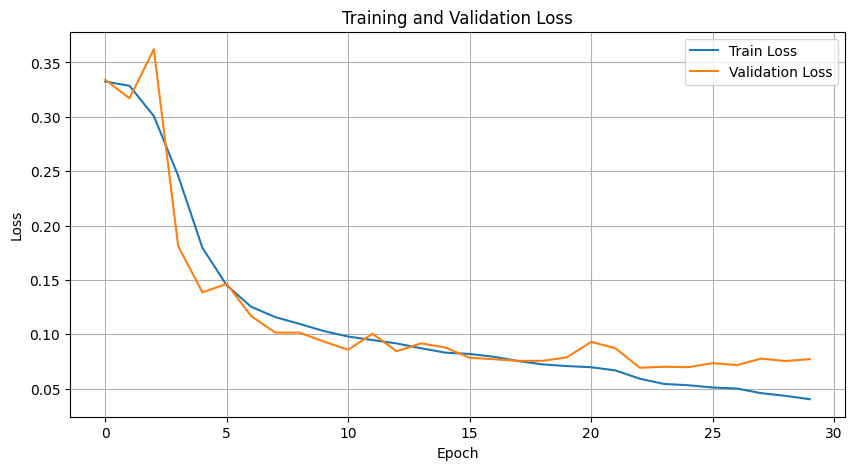


Evaluating model...
Mean Absolute Error (Age): 6.50 years
Gender Accuracy: 91.31%

Analyzing results...


C:\Users\kresi\AppData\Local\Temp\ipykernel_7848\3020230304.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_analysis = results_df.groupby(age_groups).agg({


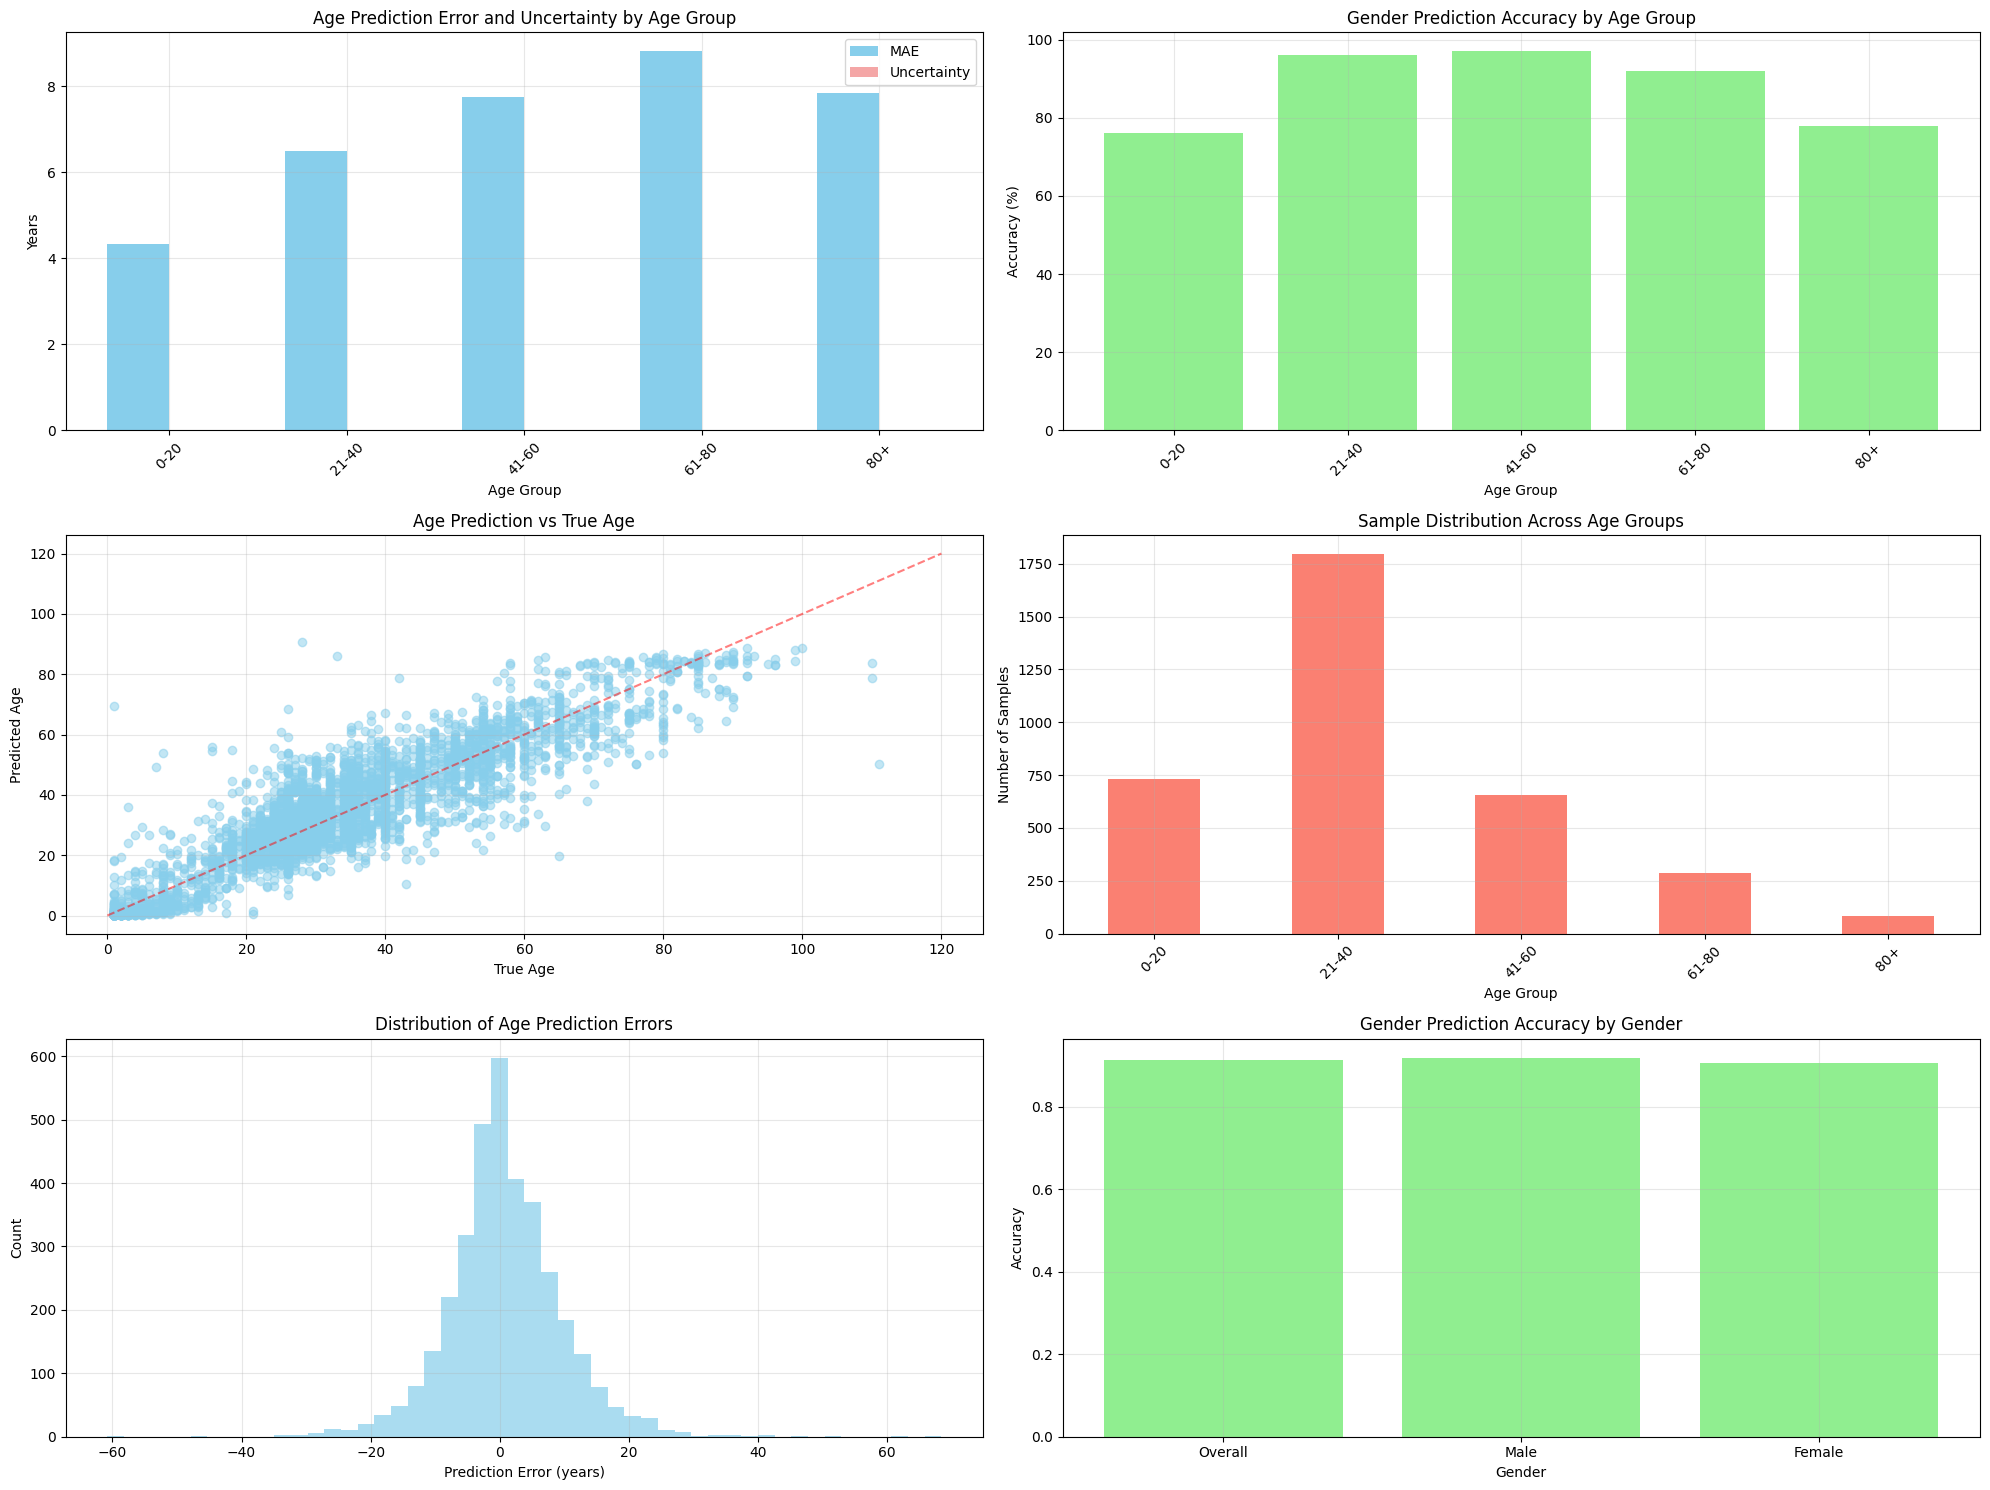


Detailed Performance Metrics:

Age Prediction MAE by Age Group:
age_true
0-20     4.33
21-40    6.50
41-60    7.74
61-80    8.81
80+      7.84
Name: age_pred, dtype: float32

Gender Prediction Accuracy by Age Group:
age_true
0-20     0.76
21-40    0.96
41-60    0.97
61-80    0.92
80+      0.78
Name: gender_pred, dtype: float64

Sample Distribution:
age_true
0-20      731
21-40    1794
41-60     658
61-80     288
80+        85
Name: age_true, dtype: int64


In [8]:
if __name__ == "__main__":
    model, mae_age, gender_accuracy, age_analysis, gender_analysis = main()


 ## 10. Save Results and Model

In [ ]:
def save_results(model, age_analysis, gender_analysis):
    """Save model and analysis results"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'age_analysis': age_analysis.to_dict(),
        'gender_analysis': gender_analysis.to_dict()
    }, 'face_analysis_results.pth')
    
    age_analysis.to_csv('age_analysis.csv')
    gender_analysis.to_csv('gender_analysis.csv')

save_results(model, age_analysis, gender_analysis)

## Conclusion

1. Model Training Performance:
- Training converged well, with loss decreasing from ~0.33 to ~0.04
- Small gap between training and validation loss after epoch 15 indicates good generalization
- No significant overfitting (validation loss stabilizes around 0.08)

2. Age Prediction Performance:
- Overall MAE: 6.50 years
- Performance varies significantly by age group:
  * Best for young (0-20): 4.33 years MAE
  * Decent for middle-aged (21-40): 6.50 years MAE
  * Degrades for older ages (61-80): 8.81 years MAE
  * Slight improvement for 80+: 7.84 years MAE (but small sample size)
- Scatter plot shows:
  * Good correlation between predicted and true ages
  * Some tendency to underestimate ages over 60
  * Increased scatter at higher ages

3. Gender Classification Performance:
- Overall accuracy: 91.31%
- Performance varies by age group:
  * Lowest for young (0-20): 76% accuracy
  * Peak for middle-aged (41-60): 97% accuracy
  * Drops for elderly (80+): 78% accuracy
- Balanced performance between genders:
  * Male and Female accuracies are very similar
  * No significant gender bias in predictions

4. Dataset Distribution:
- Significant imbalance across age groups:
  * 21-40 heavily overrepresented (1,794 samples)
  * 80+ severely underrepresented (85 samples)
  * This explains some performance variations

## Key Concerns and Recommendations:

1. Age Prediction:
- Consider age-specific loss weighting to improve elderly predictions
- Implement data augmentation focused on underrepresented age groups
- Consider ensemble models for different age ranges

2. Gender Classification:
- Need improvement for young and elderly groups
- Consider specialized models or features for these age ranges
- Implement confidence thresholds for critical applications

3. Dataset Improvements:
- Collect more samples of elderly individuals
- Balance age group representation
- Consider synthetic data generation for underrepresented groups

4. Deployment Considerations:
- Use confidence scores for critical decisions
- Implement age-specific thresholds
- Consider human verification for high-risk applications
- Regular retraining with updated, more balanced data
